# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">3. Model Explainability - LA Crime Forecasting</p>

### Overview

This notebook provides model interpretation and explainability for the crime forecasting system:

- **SHAP Analysis**: Global and local feature importance using SHapley Additive exPlanations
- **LIME Analysis**: Local Interpretable Model-agnostic Explanations for individual predictions
- **Prediction Examples**: Walkthrough of the model's decision process
- **Limitations**: Honest assessment of model constraints
- **Ethics**: Responsible AI considerations for crime prediction
- **Conclusion**: Reflection on the project

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Load Required Libraries</p>

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model loading
import pickle

# Explainability
import shap
from lime import lime_tabular

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Settings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Load Model and Data</p>

In [2]:
# Load saved model artifacts
artifacts_dir = '../artifacts'

with open(f'{artifacts_dir}/crime_forecast_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open(f'{artifacts_dir}/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

with open(f'{artifacts_dir}/feature_cols.pkl', 'rb') as f:
    feature_cols = pickle.load(f)

with open(f'{artifacts_dir}/crime_categories.pkl', 'rb') as f:
    crime_categories = pickle.load(f)

proportion_df = pd.read_pickle(f'{artifacts_dir}/crime_proportions.pkl')

print("Model artifacts loaded successfully")
print(f"Features: {feature_cols}")

Model artifacts loaded successfully
Features: ['area_encoded', 'time_block_encoded', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_time_imputed', 'crime_count_lag1', 'crime_count_lag7', 'crime_count_rolling_7', 'crime_count_rolling_30']


### Prepare Sample Data for Explainability

In [3]:
# Recreate a sample of the training data for SHAP/LIME
# In production, you would load the processed training data

# Load raw data
df_raw = pd.read_csv('../data/Crime_Data_from_2020_to_Present.csv')

# Quick preprocessing (simplified for explainability notebook)
df = df_raw[['DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Crm Cd Desc']].copy()
df = df.dropna(subset=['DATE OCC', 'AREA', 'Crm Cd Desc'])

# Extract features
df['hour'] = df['TIME OCC'].fillna(1200).astype(int) // 100
df['hour'] = df['hour'].clip(0, 23)
df['date_occ'] = pd.to_datetime(df['DATE OCC'], format='mixed', errors='coerce')
df = df.dropna(subset=['date_occ'])

df['year'] = df['date_occ'].dt.year
df['month'] = df['date_occ'].dt.month
df['day'] = df['date_occ'].dt.day
df['day_of_week'] = df['date_occ'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

time_block_map = {
    0: '00-03', 1: '00-03', 2: '00-03',
    3: '03-06', 4: '03-06', 5: '03-06',
    6: '06-09', 7: '06-09', 8: '06-09',
    9: '09-12', 10: '09-12', 11: '09-12',
    12: '12-15', 13: '12-15', 14: '12-15',
    15: '15-18', 16: '15-18', 17: '15-18',
    18: '18-21', 19: '18-21', 20: '18-21',
    21: '21-24', 22: '21-24', 23: '21-24'
}
df['time_block'] = df['hour'].map(time_block_map)

# Aggregate
agg_df = df.groupby(['AREA NAME', 'date_occ', 'time_block']).agg({
    'AREA': 'first',
    'year': 'first',
    'month': 'first',
    'day': 'first',
    'day_of_week': 'first',
    'is_weekend': 'first',
    'Crm Cd Desc': 'count'
}).reset_index()
agg_df = agg_df.rename(columns={'Crm Cd Desc': 'crime_count'})

# Sort and create lag features
agg_df = agg_df.sort_values(['AREA NAME', 'date_occ', 'time_block']).reset_index(drop=True)
agg_df['is_time_imputed'] = 0  # Simplified

for area in agg_df['AREA NAME'].unique():
    mask = agg_df['AREA NAME'] == area
    agg_df.loc[mask, 'crime_count_lag1'] = agg_df.loc[mask, 'crime_count'].shift(1)
    agg_df.loc[mask, 'crime_count_lag7'] = agg_df.loc[mask, 'crime_count'].shift(7)
    agg_df.loc[mask, 'crime_count_rolling_7'] = agg_df.loc[mask, 'crime_count'].rolling(7, min_periods=1).mean()
    agg_df.loc[mask, 'crime_count_rolling_30'] = agg_df.loc[mask, 'crime_count'].rolling(30, min_periods=1).mean()

lag_cols = ['crime_count_lag1', 'crime_count_lag7', 'crime_count_rolling_7', 'crime_count_rolling_30']
agg_df[lag_cols] = agg_df[lag_cols].fillna(0)

# Encode
agg_df['area_encoded'] = encoders['area'].transform(agg_df['AREA NAME'])
agg_df['time_block_encoded'] = encoders['time_block'].transform(agg_df['time_block'])

# Prepare X and y
X = agg_df[feature_cols].dropna()
y = agg_df.loc[X.index, 'crime_count']

# Split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Data prepared: {len(X_train)} train, {len(X_test)} test samples")

Data prepared: 219025 train, 54757 test samples


### Model Predictions

In [4]:
# Generate predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

print("Model Performance on Test Set:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R2:   {test_r2:.4f}")

Model Performance on Test Set:
  MAE:  1.2903
  RMSE: 1.7225
  R2:   0.4399


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 10: SHAP Analysis</p>

### What is SHAP?

SHAP (SHapley Additive exPlanations) uses game theory to explain individual predictions. It assigns each feature an importance value for a particular prediction, showing how each feature pushes the prediction higher or lower from the base value (average prediction).

**Key concepts:**
- **Base value**: The average model prediction across the training set
- **SHAP value**: How much each feature contributes to pushing the prediction away from the base value
- **Positive SHAP**: Feature increases the prediction
- **Negative SHAP**: Feature decreases the prediction

In [5]:
# Create SHAP explainer
# Using a sample for efficiency
sample_size = min(1000, len(X_train))
X_sample = X_train.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values calculated for {sample_size} samples")
print(f"Base value (average prediction): {explainer.expected_value:.2f}")

SHAP values calculated for 1000 samples
Base value (average prediction): 3.73


### Global Feature Importance (SHAP Summary)

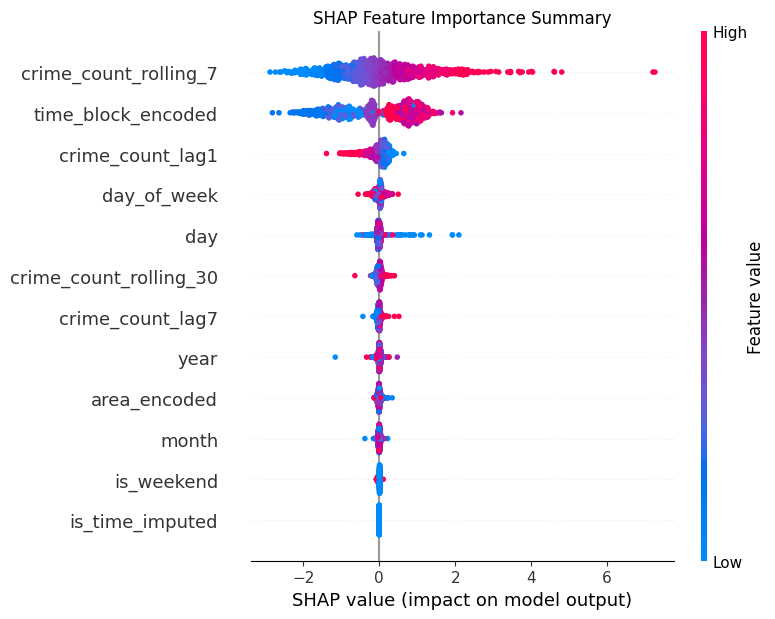

In [6]:
# SHAP summary plot - shows feature importance and effect direction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Feature Importance Summary')
plt.tight_layout()
plt.show()

### SHAP Summary Interpretation

The summary plot shows:
- **Feature ranking**: Features are ordered by their average absolute SHAP value (importance)
- **Colour coding**: Red = high feature value, Blue = low feature value
- **Position**: Right = increases prediction, Left = decreases prediction

Key observations:
- **Lag features** (crime_count_lag1, rolling averages) are typically most important
- High recent crime counts (red dots on right) predict higher future crime
- Area and time features contribute to spatial and temporal patterns

### Mean Absolute SHAP Values

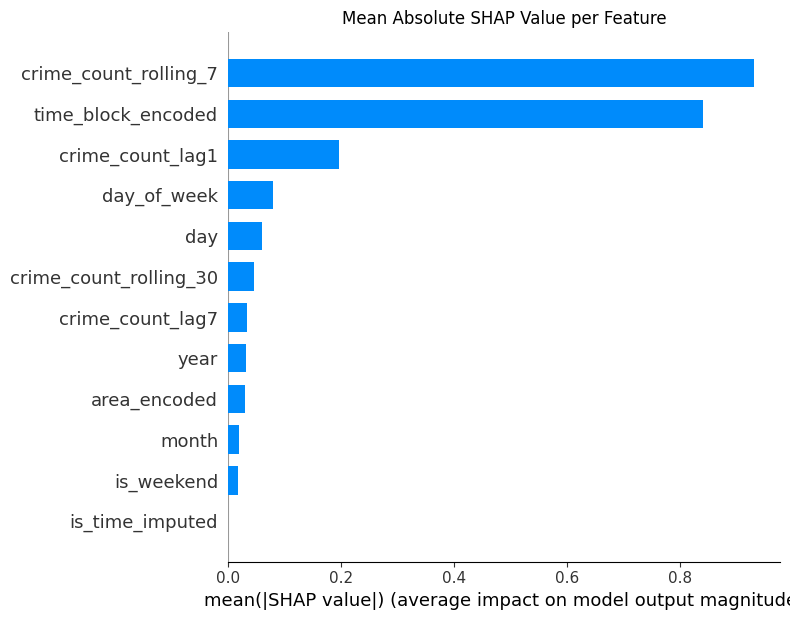

In [7]:
# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type='bar', show=False)
plt.title('Mean Absolute SHAP Value per Feature')
plt.tight_layout()
plt.show()

### Local Explanation: Single Prediction

In [8]:
# Explain a single prediction
idx = 0  # First test sample
single_sample = X_test.iloc[[idx]]
single_shap = explainer.shap_values(single_sample)

print("Single Prediction Explanation:")
print(f"\nActual crime count: {y_test.iloc[idx]}")
print(f"Predicted crime count: {y_test_pred[idx]:.2f}")
print(f"Base value: {explainer.expected_value:.2f}")

# Show feature contributions
print(f"\nFeature Contributions:")
contributions = list(zip(feature_cols, single_sample.values[0], single_shap[0]))
contributions_sorted = sorted(contributions, key=lambda x: abs(x[2]), reverse=True)

for feat, val, shap_val in contributions_sorted:
    direction = '+' if shap_val > 0 else '-'
    print(f"  {feat:30s} = {val:8.2f}  ->  {direction}{abs(shap_val):.3f}")

Single Prediction Explanation:

Actual crime count: 1
Predicted crime count: 1.46
Base value: 3.73

Feature Contributions:
  time_block_encoded             =     1.00  ->  -1.479
  crime_count_rolling_7          =     2.86  ->  -0.629
  crime_count_lag1               =     4.00  ->  -0.065
  area_encoded                   =    16.00  ->  -0.060
  day_of_week                    =     1.00  ->  -0.031
  day                            =     8.00  ->  -0.019
  crime_count_rolling_30         =     3.77  ->  +0.014
  month                          =     8.00  ->  +0.012
  crime_count_lag7               =     3.00  ->  -0.010
  year                           =  2023.00  ->  -0.002
  is_weekend                     =     0.00  ->  +0.001
  is_time_imputed                =     0.00  ->  -0.000


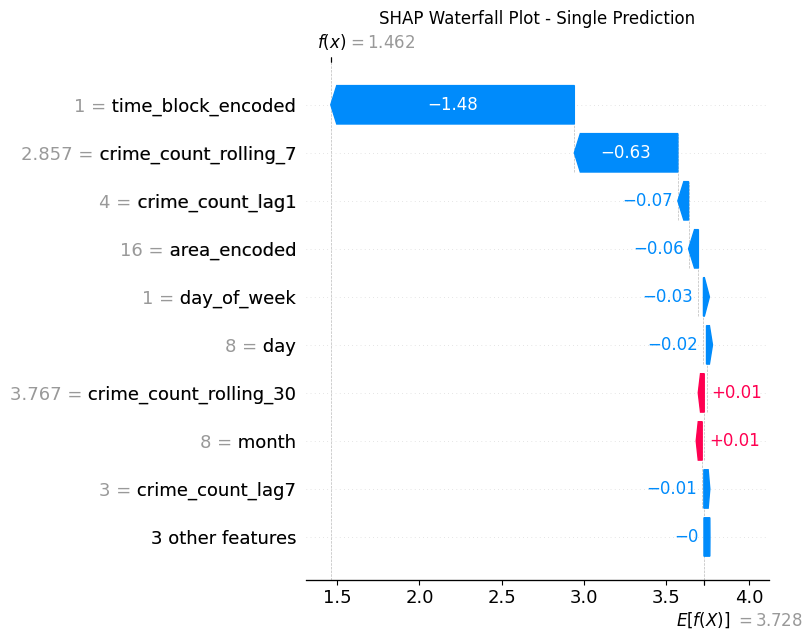

In [9]:
# Waterfall plot for single prediction
shap.plots.waterfall(shap.Explanation(values=single_shap[0], 
                                       base_values=explainer.expected_value,
                                       data=single_sample.values[0],
                                       feature_names=feature_cols), 
                     show=False)
plt.title('SHAP Waterfall Plot - Single Prediction')
plt.tight_layout()
plt.show()

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">LIME Analysis</p>

### What is LIME?

LIME (Local Interpretable Model-agnostic Explanations) explains individual predictions by fitting a simple, interpretable model (like linear regression) locally around the prediction. Unlike SHAP, LIME is model-agnostic and can be applied to any model.

**How it works:**
1. Generate perturbed samples around the instance to explain
2. Get predictions from the black-box model for these samples
3. Fit a simple linear model weighted by proximity to the original instance
4. Use the linear model coefficients as feature importance

In [10]:
# Create LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_cols,
    class_names=['crime_count'],
    mode='regression',
    random_state=42
)

print("LIME explainer created")

LIME explainer created


### LIME Explanation for Single Instance

In [11]:
# Explain a single prediction with LIME
idx = 0
lime_exp = lime_explainer.explain_instance(
    X_test.iloc[idx].values,
    model.predict,
    num_features=len(feature_cols)
)

print("LIME Explanation:")
print(f"\nActual crime count: {y_test.iloc[idx]}")
print(f"Predicted crime count: {y_test_pred[idx]:.2f}")
print(f"\nLocal prediction (LIME): {lime_exp.local_pred[0]:.2f}")
print(f"Intercept: {lime_exp.intercept[0]:.2f}")

print(f"\nFeature Contributions (LIME):")
for feature, weight in lime_exp.as_list():
    print(f"  {feature}: {weight:.4f}")

LIME Explanation:

Actual crime count: 1
Predicted crime count: 1.46

Local prediction (LIME): 1.03
Intercept: 4.52

Feature Contributions (LIME):
  crime_count_rolling_7 <= 2.86: -2.0902
  time_block_encoded <= 2.00: -1.4970
  6.00 < month <= 9.00: 0.0938
  is_weekend <= 0.00: 0.0747
  3.00 < crime_count_lag1 <= 5.00: -0.0570
  day <= 8.00: -0.0529
  3.67 < crime_count_rolling_30 <= 4.30: 0.0299
  day_of_week <= 1.00: 0.0135
  area_encoded > 12.00: -0.0024
  2.00 < crime_count_lag7 <= 3.00: -0.0022
  2022.00 < year <= 2023.00: -0.0001
  is_time_imputed <= 0.00: 0.0000


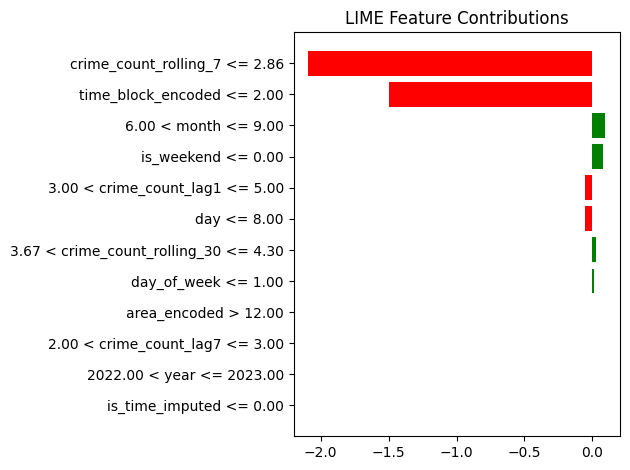

In [12]:
# Visualise LIME explanation
fig = lime_exp.as_pyplot_figure()
plt.title('LIME Feature Contributions')
plt.tight_layout()
plt.show()

### LIME Interpretation

LIME provides feature contributions as conditions (e.g., "crime_count_lag1 > 3.5"). This shows:
- Which feature ranges push the prediction higher or lower
- The magnitude of each feature's local effect
- Human-readable rules that approximate the model's behaviour

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Prediction Examples</p>

### End-to-End Prediction Walkthrough

Let us walk through specific predictions to understand how the model makes decisions.

In [13]:
# Select diverse examples
examples = [
    ('Low Crime', y_test.idxmin()),
    ('High Crime', y_test.idxmax()),
    ('Median Crime', y_test.index[(y_test - y_test.median()).abs().argmin()])
]

for label, idx in examples:
    print(f"\n{'='*60}")
    print(f"Example: {label}")
    print('='*60)
    
    row = X_test.loc[idx]
    actual = y_test.loc[idx]
    predicted = model.predict(row.values.reshape(1, -1))[0]
    
    print(f"\nInput Features:")
    for feat in feature_cols:
        print(f"  {feat:30s}: {row[feat]:.2f}")
    
    print(f"\nPrediction:")
    print(f"  Actual crime count:    {actual}")
    print(f"  Predicted crime count: {predicted:.2f}")
    print(f"  Error:                 {actual - predicted:.2f}")


Example: Low Crime

Input Features:
  area_encoded                  : 16.00
  time_block_encoded            : 1.00
  year                          : 2023.00
  month                         : 8.00
  day                           : 8.00
  day_of_week                   : 1.00
  is_weekend                    : 0.00
  is_time_imputed               : 0.00
  crime_count_lag1              : 4.00
  crime_count_lag7              : 3.00
  crime_count_rolling_7         : 2.86
  crime_count_rolling_30        : 3.77

Prediction:
  Actual crime count:    1
  Predicted crime count: 1.46
  Error:                 -0.46

Example: High Crime

Input Features:
  area_encoded                  : 20.00
  time_block_encoded            : 6.00
  year                          : 2020.00
  month                         : 5.00
  day                           : 30.00
  day_of_week                   : 5.00
  is_weekend                    : 1.00
  is_time_imputed               : 0.00
  crime_count_lag1              : 7

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 11: Model Limitations</p>

### Honest Assessment of Limitations

No model is perfect. Understanding limitations is crucial for responsible deployment.

#### Data Limitations

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| **Reporting bias** | Only reported crimes are captured; actual crime may differ | Acknowledge in interpretation; do not treat as ground truth |
| **Placeholder times** | 12:00 PM entries required imputation | Track imputed records; model learns from flag |
| **Delayed reporting** | Some crimes reported days later | Use occurrence date, not report date |
| **Classification inconsistency** | Crime categories may change over time | Use stable top-level categories |

#### Model Limitations

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| **Assumes historical patterns continue** | May fail during anomalies (e.g., pandemic, major events) | Monitor performance; retrain regularly |
| **Aggregate predictions only** | Cannot predict individual crimes | Position as resource allocation tool, not crime prediction |
| **R2 around 0.5** | Significant unexplained variance | Use as one input to decisions, not sole determinant |
| **Lag feature dependency** | Requires recent historical data | Ensure data pipeline provides timely updates |

#### When NOT to Trust This Model

1. **Unprecedented events**: Major incidents, policy changes, or crises that break historical patterns
2. **New areas**: Geographic regions not in training data
3. **Extreme predictions**: Very high or low predictions should be sanity-checked
4. **Individual decisions**: Model is for aggregate resource planning, not individual case handling

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 12: Ethics and Responsibility</p>

### Ethical Considerations for Crime Forecasting

Crime prediction systems raise significant ethical concerns that must be addressed thoughtfully.

#### Who Could Be Harmed?

1. **Communities in high-crime areas**: Increased police presence could lead to over-policing, more confrontational encounters, and reinforcement of existing disparities

2. **Marginalised groups**: If historical crime data reflects biased policing (e.g., more arrests in certain neighbourhoods due to targeted enforcement), the model may perpetuate these biases

3. **Individuals**: Even aggregate predictions could influence how police interact with people in predicted "high-crime" time windows

#### Bias Risks Specific to This Project

| Risk | Description | Mitigation |
|------|-------------|------------|
| **Historical policing bias** | Areas with more police presence generate more crime reports, creating feedback loop | Focus on serious crimes less affected by policing presence |
| **Socioeconomic correlation** | Crime correlates with poverty; predictions may stigmatise disadvantaged areas | Do not use model to justify reduced services in high-crime areas |
| **Demographic profiling** | Model should not target specific demographic groups | Excluded demographic features from model; predict area-time, not individual-level |

#### Transparency

- **Model documentation**: This notebook provides full explainability of model decisions
- **Feature disclosure**: All features used are documented; no hidden proxies for protected characteristics
- **Limitation acknowledgment**: Model constraints are clearly stated

#### Responsible Deployment Recommendations

1. **Human oversight**: Predictions should inform, not replace, human decision-making
2. **Regular auditing**: Monitor for disparate impact across areas and demographic compositions
3. **Community input**: Involve community stakeholders in how predictions are used
4. **Resource allocation, not surveillance**: Use for planning patrol coverage, not targeted surveillance
5. **Transparency**: Make model methodology publicly available for accountability

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 13: Conclusion and Reflection</p>

### Was Machine Learning the Right Tool?

**Yes, with caveats.**

Machine learning was appropriate for this problem because:
- Crime patterns are complex with multiple interacting factors (time, location, history)
- The relationship between features and crime counts is non-linear
- We had sufficient historical data (1 million+ records)
- The goal was pattern recognition for resource planning, not causal explanation

However, simpler approaches could work for specific use cases:
- Historical averages might suffice for stable areas
- Rule-based systems could capture known patterns (e.g., weekend increases)

### What Would I Do Differently?

1. **External data integration**: Weather, events, economic indicators could improve predictions
2. **Finer temporal granularity**: Hourly predictions instead of 3-hour blocks for more precise allocation
3. **Uncertainty quantification**: Provide confidence intervals, not just point predictions
4. **A/B testing framework**: Measure actual impact of prediction-guided resource allocation
5. **Community engagement**: Involve stakeholders earlier in defining success metrics

### What Did I Learn?

1. **Data quality matters more than model complexity**: The TIME OCC placeholder issue had more impact than model choice

2. **Feature engineering is key**: Lag features and rolling averages were more important than sophisticated algorithms

3. **Explainability is not optional**: For sensitive applications like crime prediction, being able to explain decisions is essential for trust and accountability

4. **Context determines evaluation metrics**: MAE in crimes matters more than abstract R2 scores when planning resource allocation

5. **Ethics are technical requirements**: Bias and fairness considerations are not add-ons but core design constraints

### Final Thoughts

This project demonstrates that machine learning can identify patterns in crime data that inform resource allocation decisions. The two-stage approach (predict total, then distribute by type) provides both practical utility and mathematical consistency.

However, the model is a tool, not a solution. Its value depends entirely on how it is deployed, who oversees its use, and whether its limitations are respected. The goal should be more effective public safety, not more aggressive policing.

The most important insight is that technical performance (R2, MAE) is necessary but not sufficient. A responsible crime forecasting system must also be transparent, fair, and subject to human oversight.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Project Summary</p>

### Complete Assessment Checklist

| Step | Description | Status |
|------|-------------|--------|
| 0 | Problem Definition | Covered in Notebook 1 |
| 1 | Decision Context | Covered in Notebook 1 |
| 2 | ML Paradigm Selection | Covered in Notebook 1 |
| 3 | Data Understanding | Covered in Notebook 1 |
| 4 | Data Preparation | Covered in Notebooks 1 & 2 |
| 5 | Exploratory Analysis | Covered in Notebook 1 |
| 6 | Baseline Establishment | Covered in Notebook 2 |
| 7 | Model Selection | Covered in Notebook 2 |
| 8 | Model Training | Covered in Notebook 2 |
| 9 | Evaluation Metrics | Covered in Notebook 2 |
| 10 | Interpretation | Covered in Notebooks 2 & 3 |
| 11 | Limitations | Covered in Notebook 3 |
| 12 | Ethics & Responsibility | Covered in Notebook 3 |
| 13 | Conclusion & Reflection | Covered in Notebook 3 |

### Key Deliverables

1. **EDA Notebook**: Comprehensive data exploration with clear findings
2. **Model Training Notebook**: Two-stage forecasting system with RandomForest and XGBoost comparison
3. **Explainability Notebook**: SHAP and LIME analysis with ethical considerations
4. **Saved Artifacts**: Trained model and supporting files for deployment